In [50]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [51]:
PACKAGE_USED = 0  # 0 = sklearn; 1 = sktime; 2 = aeon

In [52]:
APPROACH = "rf"

In [53]:
CHANNEL_CONFIG = "g-a"

In [54]:
TRAIN_DIR = [
    R"dataset\v2_gold_annotation",
    R"dataset\v2_minx_annotation",
    R"dataset\v4_timo_annotation",
    R"dataset\v4_gracia_annotation",
    R"dataset\v5_cel_annotation"
]

In [55]:
TEST_DIR = [
    R"dataset\v4_gil_annotation"
]

# Build DataFrame

In [56]:
def build_df(dirs):
    """
    dirs: list of directory paths containing CSV files
    """
    all_csv_files = []

    for _DIR in dirs:
        file_pattern = os.path.join(_DIR, "*.csv")
        csv_files = glob.glob(file_pattern)
        print(f"{_DIR} -> {len(csv_files)} CSV files found")
        all_csv_files.extend(csv_files)

    print(f"A total of {len(all_csv_files)} CSV files were used in constructing this DataFrame.")

    if not all_csv_files:
        raise ValueError("No CSV files found in the provided directories.")

    df = pd.concat((pd.read_csv(f) for f in all_csv_files), ignore_index=True)
    return df

In [57]:
df_train = build_df(TRAIN_DIR)

dataset\v2_gold_annotation -> 16 CSV files found
dataset\v2_minx_annotation -> 10 CSV files found
dataset\v4_timo_annotation -> 19 CSV files found
dataset\v4_gracia_annotation -> 10 CSV files found
dataset\v5_cel_annotation -> 16 CSV files found
A total of 71 CSV files were used in constructing this DataFrame.


In [58]:
df_test = build_df(TEST_DIR)

dataset\v4_gil_annotation -> 25 CSV files found
A total of 25 CSV files were used in constructing this DataFrame.


In [59]:
print(df_train.duplicated().sum())

13


In [60]:
print(df_test.duplicated().sum())

28


In [61]:
df_train.drop_duplicates(inplace=True)

In [62]:
df_test.drop_duplicates(inplace=True)

## Remove unneeded columns

In [63]:
match CHANNEL_CONFIG:
    case "gyro":
        df_train = df_train.filter(regex=r'^(gyro|motion)')
        df_test = df_test.filter(regex=r'^(gyro|motion)')
    case "accel":
        df_train = df_train.filter(regex=r'^(accel|motion)')
        df_test = df_test.filter(regex=r'^(accel|motion)')
    case "mag":
        df_train = df_train.filter(regex=r'^(mag|motion)')
        df_test = df_test.filter(regex=r'^(mag|motion)')
    case "ahrs":
        df_train = df_train.filter(regex=r'^(ahrs|motion)')
        df_test = df_test.filter(regex=r'^(ahrs|motion)')
    case "g-a":
        df_train = df_train.filter(regex=r'^(gyro|accel|motion)')
        df_test = df_test.filter(regex=r'^(gyro|accel|motion)')
    case "g-m":
        df_train = df_train.filter(regex=r'^(gyro|mag|motion)')
        df_test = df_test.filter(regex=r'^(gyro|mag|motion)')
    case "a-m":
        df_train = df_train.filter(regex=r'^(accel|mag|motion)')
        df_test = df_test.filter(regex=r'^(accel|mag|motion)')
    case "g-a-m":
        df_train = df_train.filter(regex=r'^(gyro|accel|mag|motion)')
        df_test = df_test.filter(regex=r'^(gyro|accel|mag|motion)')
    case _:
        pass

In [64]:
df_train = df_train.drop(df_train[df_train["motion_type"] == "POUR"].index)
df_train = df_train.drop(df_train[df_train["motion_type"] == "TILT_UP"].index)
df_train = df_train.drop(df_train[df_train["motion_type"] == "TILT_DOWN"].index)
df_train = df_train.drop(df_train[df_train["motion_type"] == "STIR"].index)
df_train = df_train.drop(df_train[df_train["motion_type"] == "ROLL"].index)


In [65]:
df_train.head()

,gyro_x_0,gyro_y_0,gyro_z_0,accel_x_0,accel_y_0,accel_z_0,gyro_x_1,gyro_y_1,gyro_z_1,accel_x_1,...,accel_x_28,accel_y_28,accel_z_28,gyro_x_29,gyro_y_29,gyro_z_29,accel_x_29,accel_y_29,accel_z_29,motion_type
0,-5.048313,0.544225,2.133175,4.55400,8.42100,-4.45695,-4.849900,0.211475,1.034825,4.50105,...,7.38495,-4.68300,-1.177950,6.140613,4.273912,-5.951687,7.384950,-4.68300,-1.177950,HIT
1,0.511087,-0.001787,0.113850,7.98405,3.99495,-2.43300,0.511087,-0.001787,0.113850,7.98405,...,8.63805,-4.89405,-6.553051,5.875513,6.787962,-5.628287,8.638050,-4.89405,-6.553051,HIT
2,0.689975,-0.069025,-0.549450,5.70405,7.45095,-2.50305,0.689975,-0.069025,-0.549450,5.70405,...,7.17705,-5.79900,-4.045050,3.287075,4.430663,-5.384225,7.177050,-5.79900,-4.045050,HIT
3,-2.874850,-0.293012,-0.687638,5.19105,8.42805,-3.96105,-2.874850,-0.293012,-0.687638,5.19105,...,8.50800,-0.89205,-2.488050,3.713600,1.932150,-4.427638,8.508000,-0.89205,-2.488050,HIT
4,0.170775,0.027500,-0.111787,7.15005,3.16905,-0.74505,0.170775,0.027500,-0.111787,7.15005,...,6.98700,-2.47695,-2.062050,-10.236600,12.141250,2.020150,7.918951,-1.33005,-2.650950,HIT


In [66]:
df_test.head()

,gyro_x_0,gyro_y_0,gyro_z_0,accel_x_0,accel_y_0,accel_z_0,gyro_x_1,gyro_y_1,gyro_z_1,accel_x_1,...,accel_x_28,accel_y_28,accel_z_28,gyro_x_29,gyro_y_29,gyro_z_29,accel_x_29,accel_y_29,accel_z_29,motion_type
0,0.910801,1.614941,-3.147856,5.267244,3.193865,-1.798046,0.769654,1.470598,-3.043461,4.824317,...,8.264784,-10.393229,-1.877054,-0.047937,0.826113,-1.589375,7.484274,-10.761936,-0.505177,HIT
1,0.113983,-0.014914,-0.573112,-0.210690,11.956643,1.778892,0.565123,-0.605603,0.524643,-2.777274,...,6.579266,-6.011840,0.349553,0.131560,-0.346744,-2.452239,6.983886,-6.830657,-0.869095,HIT
2,-0.353668,-0.837298,-0.193878,2.559402,8.214506,-1.944092,-0.452205,-0.645550,-0.045806,1.558625,...,4.647145,-7.809886,-0.497994,0.445813,0.611462,-4.975850,4.299986,-4.357447,-2.183512,HIT
3,0.426638,1.139833,-3.861584,5.674258,2.530671,-1.498770,0.544883,1.139833,-3.845605,5.674258,...,10.151415,-14.700398,-5.434838,0.322242,1.669802,-2.238653,10.151415,-14.700398,-5.434838,HIT
4,-0.495348,-0.371245,-0.364320,2.573767,9.282320,-1.972822,-0.686563,-0.253000,-0.157659,1.946486,...,6.308722,-7.953538,-1.692701,0.339819,0.446346,-1.404019,6.828263,-8.044518,-1.817199,HIT


<Axes: xlabel='motion_type', ylabel='count'>

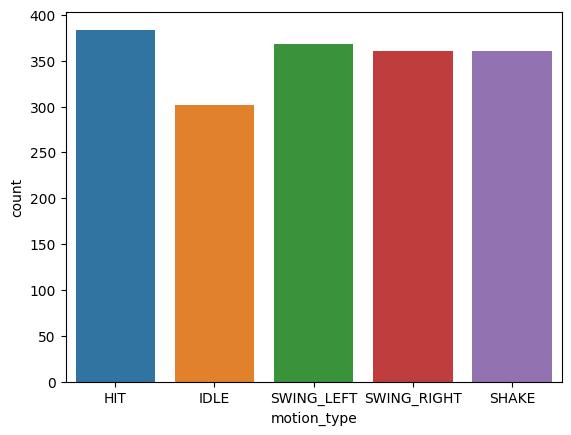

In [67]:
sns.countplot(df_train, x="motion_type", hue="motion_type")

In [68]:
len(df_train)

1776

<Axes: xlabel='motion_type', ylabel='count'>

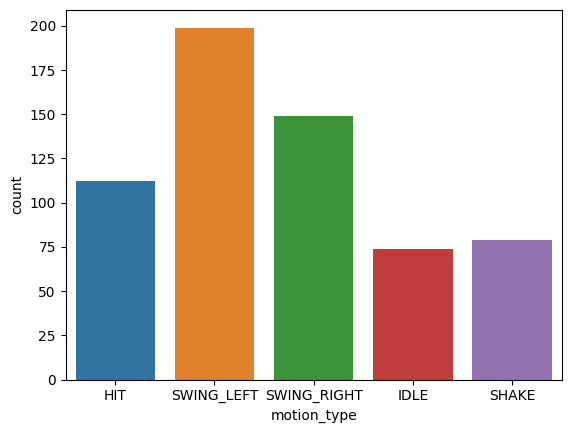

In [69]:
sns.countplot(df_test, x="motion_type", hue="motion_type")

In [70]:
len(df_test)

613

## Get X and y

In [71]:
from sklearn.preprocessing import LabelEncoder

In [72]:
def get_X_and_y(df: pd.DataFrame, package_used: int) -> tuple[np.array, np.array]:
    if package_used == 0:  # sklearn
        X = df.drop(columns=["motion_type"]).values
        y = df["motion_type"].values
        return X.astype("float32"), y
    
    elif package_used == 1:  # sktime
        X_df = df.drop(columns=["motion_type"])
        y = df["motion_type"].values
        
        n_timesteps = 30
        channels = []
        match CHANNEL_CONFIG:
            case "accel":
                channels = ["accel_x", "accel_y", "accel_z"]
            case "gyro":
                channels = ["gyro_x", "gyro_y", "gyro_z"]
            case "mag":
                channels = ["mag_x", "mag_y", "mag_z"]
            case "ahrs":
                channels = ["ahrs_x", "ahrs_y", "ahrs_z", "ahrs_w"]
            case "g-a":
                channels = ["gyro_x", "gyro_y", "gyro_z", "accel_x", "accel_y", "accel_z"]
            case "g-m":
                channels = ["gyro_x", "gyro_y", "gyro_z", "mag_x", "mag_y", "mag_z"]
            case "a-m":
                channels = ["accel_x", "accel_y", "accel_z", "mag_x", "mag_y", "mag_z"]
            case "g-a-m":
                channels = ["gyro_x", "gyro_y", "gyro_z", "accel_x", "accel_y", "accel_z", "mag_x", "mag_y", "mag_z"]
            case _:
                channels = ["gyro_x", "gyro_y", "gyro_z", "accel_x", "accel_y", "accel_z", "mag_x", "mag_y", "mag_z", "ahrs_x", "ahrs_y", "ahrs_z", "ahrs_w"]
        n_channels = len(channels)

        X = np.zeros((len(df), n_channels, n_timesteps))

        for t in range(n_timesteps):
            for c, channel in enumerate(channels):
                col_name = f"{channel}_{t}"
        
                X[:, c, t] = X_df[col_name].values
                
        return X.astype("float32"), y

    else:  # aeon
        y = df["motion_type"].values

        n_timesteps = 30

        channels = {
            "accel": ["accel_x", "accel_y", "accel_z"],
            "gyro": ["gyro_x", "gyro_y", "gyro_z"],
            "mag": ["mag_x", "mag_y", "mag_z"],
            "ahrs": ["ahrs_x", "ahrs_y", "ahrs_z", "ahrs_w"],
            "g-a": ["gyro_x", "gyro_y", "gyro_z", "accel_x", "accel_y", "accel_z"],
            "g-m": ["gyro_x", "gyro_y", "gyro_z", "mag_x", "mag_y", "mag_z"],
            "a-m": ["accel_x", "accel_y", "accel_z", "mag_x", "mag_y", "mag_z"],
            "g-a-m": ["gyro_x", "gyro_y", "gyro_z",
                    "accel_x", "accel_y", "accel_z",
                    "mag_x", "mag_y", "mag_z"],
        }.get(CHANNEL_CONFIG, [
            "gyro_x","gyro_y","gyro_z",
            "accel_x","accel_y","accel_z",
            "mag_x","mag_y","mag_z",
            "ahrs_x","ahrs_y","ahrs_z","ahrs_w"
        ])

        n_channels = len(channels)
        X = np.zeros((len(df), n_channels, n_timesteps), dtype="float32")

        for t in range(n_timesteps):
            for c, ch in enumerate(channels):
                X[:, c, t] = df[f"{ch}_{t}"].values

        return X.astype("float32"), y

In [73]:
X_train, y_train = get_X_and_y(df_train, PACKAGE_USED)
X_test, y_test = get_X_and_y(df_test, PACKAGE_USED)

In [74]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [75]:
le.classes_

array(['HIT', 'IDLE', 'SHAKE', 'SWING_LEFT', 'SWING_RIGHT'], dtype=object)

In [76]:
from sktime.classification.kernel_based import RocketClassifier
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.deep_learning import InceptionTimeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from aeon.classification.deep_learning import LITETimeClassifier

In [77]:
if PACKAGE_USED == 0:
    if APPROACH.lower() == "svm":
        clf_minirocket = SVC()
    elif APPROACH.lower() == "rf":
        clf_minirocket = RandomForestClassifier()
    elif APPROACH.lower() == "softmax":
        clf_minirocket = LogisticRegression()

In [78]:
if PACKAGE_USED == 1:
    if APPROACH.lower() == "knn":
        clf_minirocket = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
    elif APPROACH.lower() == "minirocket":
        clf_minirocket = make_pipeline(
            MiniRocketMultivariate(random_state=42),
            RidgeClassifier(alpha=1.0)
        )

In [79]:
if PACKAGE_USED == 2:
    if APPROACH.lower() == "litemvtime":
        clf_minirocket = LITETimeClassifier(use_litemv=True)

In [80]:
clf_minirocket.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [81]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [82]:
y_pred_train = clf_minirocket.predict(X_train)

In [83]:
print(accuracy_score(y_train, y_pred_train))
print(precision_score(y_train, y_pred_train, average="weighted"))
print(recall_score(y_train, y_pred_train, average="weighted"))
print(f1_score(y_train, y_pred_train, average="weighted"))

1.0
1.0
1.0
1.0


In [84]:
y_pred_test = clf_minirocket.predict(X_test)

In [85]:
print(accuracy_score(y_test, y_pred_test))
print(precision_score(y_test, y_pred_test, average="weighted", zero_division=0))
print(recall_score(y_test, y_pred_test, average="weighted", zero_division=0))
print(f1_score(y_test, y_pred_test, average="weighted", zero_division=0))

0.9380097879282219
0.9403657814053396
0.9380097879282219
0.9374959526463048


In [86]:
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

[[ 98   0  13   1   0]
 [  7  59   2   0   6]
 [  0   0  79   0   0]
 [  0   7   0 190   2]
 [  0   0   0   0 149]]


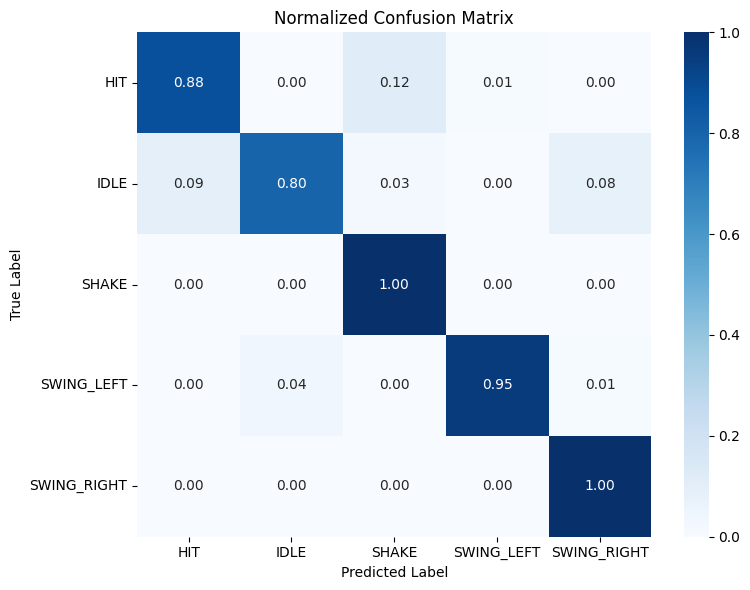

In [87]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = le.classes_.tolist()

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_normalized,              # use cm for raw counts
    annot=True,                 # write numbers inside cells
    fmt=".2f",                  # 2 decimal places
    cmap="Blues",               # color style
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.savefig(f"cmat_{APPROACH}.png")
plt.show()

In [88]:
from sklearn.metrics import classification_report

In [89]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       112
           1       0.89      0.80      0.84        74
           2       0.84      1.00      0.91        79
           3       0.99      0.95      0.97       199
           4       0.95      1.00      0.97       149

    accuracy                           0.94       613
   macro avg       0.92      0.93      0.92       613
weighted avg       0.94      0.94      0.94       613



In [90]:
from time import perf_counter

In [91]:
t0 = perf_counter()
a = clf_minirocket.predict(X_train[0:1])
t1 = perf_counter()

In [92]:
print(f"{t1 - t0} seconds taken to perform a single inference!")

0.024129900000843918 seconds taken to perform a single inference!


In [93]:
from skl2onnx import to_onnx

if PACKAGE_USED == 0:
    onx = to_onnx(clf_minirocket, X_train[:1])
    with open(f"clf_{APPROACH}.onnx", "wb") as f:
        f.write(onx.SerializeToString())

In [94]:
from joblib import dump

dump(clf_minirocket, f"clf_{APPROACH}.joblib")

['clf_rf.joblib']

In [95]:
# clf_minirocket.predict(X_train[0:1])

In [96]:
# print(repr(X_train[0:1]))

In [97]:
# print(repr(y_train[0]))